[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TomGeorge1234/HelmholtzHippocampus/blob/main/figs12.ipynb)


# Figures 1 & 2 
This code replicates core results from figures 1, 2 and S1 showing the Helmholtz machine model can learn to autoencode temporally random sensory stimuli.

<img src="./images/nf1.png" width=400>

<img src="./images/nf2.png" width=400>

<img src="./images/nfs1.png" width=400>


## 0 Install and import dependencies

In [20]:
# Install RatInABox whih is a python package we use for simulating this neural data
!pip install wget ratinabox==1.6.3 tomplotlib==1.2.2 

In [18]:
#Import HH_utils (where all the project code is) and ratinabox
#downloads the utils functions 
import os
if os.path.exists("HH_utils.py"): pass
else: wget.download("https://github.com/TomGeorge1234/HelmholtzHippocampus/raw/main/HH_utils.py"); print("...utils downloaded!")
from HH_utils import (GaussianProcessNeurons,
                      PyramidalNeurons, 
                      run_simulation,
                      autocorrelations,)


from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import FeedForwardLayer

import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1 Construct the basic architecture: 
* `Latents`: Neurons which have smoothly but randomly time varying firing rates 
* `Features`: A linear mixture of latents with random weights
* `HPC`: Pyramidal neurons recieving bottom-up input from features and top-down input from MEC
* `MEC`: Pyramidal neurons recieving bottom-up input from HPC and top-down input itself

In [3]:
# Make the environment and agent.
# In this abstract setting they are slightly redundant and just ways to access the neurons classes written in RatInABox.
Env = Environment(params={'boundary_conditions':'periodic','dimensionality':'1D'})
Ag = Agent(Env, params={'dt':25e-3})

#Global constants 
THETA_FREQ = 5         # theta frequency 
THETA_FUNC = 'square'  # theta shape
TAU = 1                # timescale of the latent variables
N_LATENTS = 5          # number of latent variables
W_INIT_SCALE = 1       # scale of the initial weights
ETA = 0.01             # learning rate
TAU_PI = 100e-3        # timescale of the discrepancy error 
L2 = 0.005            # L2 regularization strength on MEC apical inputs 

# Make the neurons.
Latents = GaussianProcessNeurons(Ag,
        params={'timescales':np.array([TAU,TAU,TAU,TAU,TAU]),
                'color':'C4',
                'n':N_LATENTS,
                'offset':0})

Features = FeedForwardLayer(Ag, 
        params={'n':10*N_LATENTS, 
                'color':'C7',
                'name':'Features',
                'activation_params':{'activation':'linear'},})

HPC = PyramidalNeurons(Ag,
    params={
         'name':'HPC',
         'theta_func':THETA_FUNC,
         'theta_freq':THETA_FREQ,
         'theta_phase_offset':0,
         'n':10*N_LATENTS,
         'color':'C2',
         })

EC = PyramidalNeurons(Ag,
        params={
        'name':'EC',
        'theta_func':THETA_FUNC,
        'theta_freq':THETA_FREQ,
        'n':N_LATENTS,
        'color':'C0',
        })
EC.apical_compartment.noise_scale = 0.05 #make apical noise a bit larger, this is necesary to "seed" generative activity

/Users/tomgeorge/miniconda3/envs/HHH/lib/python3.11/site-packages/ratinabox/Neurons.py:1766: UserWarning: No input layers have been provided. Either hand them in in the params dictionary params['input_layers']=[list,of,inputs] or use self.add_input_layer() to add them manually.
  warnings.warn(


### 1.1 Connect the neurons together
as described in the paper: Latents --> Features --> HPC <--> MEC <--> MEC

In [4]:
Features.add_input(Latents,w_init_scale=W_INIT_SCALE)

HPC.basal_compartment.add_input(Features,eta=0)
HPC.basal_compartment.inputs['Features']['w'] = np.identity(HPC.n)

HPC.apical_compartment.add_input(EC,eta=ETA,w_init=1,tau_PI=TAU_PI)
EC.basal_compartment.add_input(HPC,eta=ETA,w_init=1,tau_PI=TAU_PI)

EC.apical_compartment.add_input(EC,eta=ETA,w_init=0.1,tau_PI=TAU_PI, L2=L2)

layers=[Latents,Features,HPC,EC]

## 2 Visualise network activity before learning 

### 2.1 Inference mode 
`run_simulation()` function takes `layers` (list of all neurons layers) as well as the agent and updates them for a fixed amount of time. Data is stored inside each neurons class. 

* First we will run the network for 1 minute with the model in **inference mode (bottom-up drive)**. You should observe that somatic activity equals basal dendritic activity since the network is in inference mode, but does not necessarily match apical dendritic activity.

  0%|          | 0/2400 [00:00<?, ?it/s]

<Loss> = [('HPC', '5.75e-01'), ('EC', '4.08e-01')]: 100%|██████████| 2400/2400 [00:00<00:00, 3208.40it/s]


Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/EC_apical_firingrate_1444.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/EC_firingrate_1444.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/EC_basal_firingrate_1444.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/HPC_apical_firingrate_1444.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/HPC_firingrate_1444.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/HPC_basal_firingrate_1444.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/Neurons_firingrate_1444.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/Features_firingrate_1444.png  & .svg


(<Figure size 600x60 with 1 Axes>,
 <Axes: xlabel='Time / min', ylabel='Neurons'>)

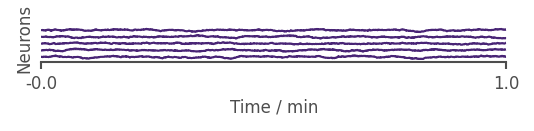

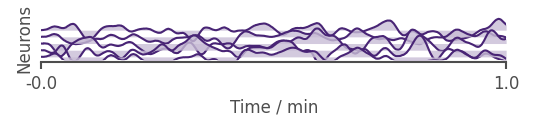

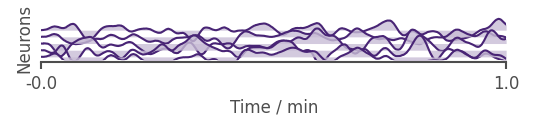

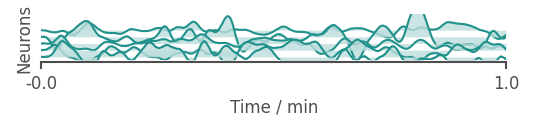

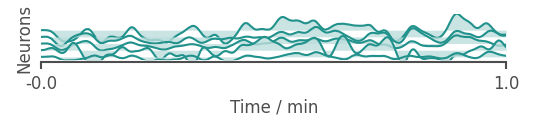

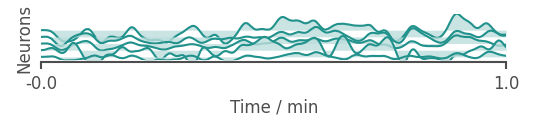

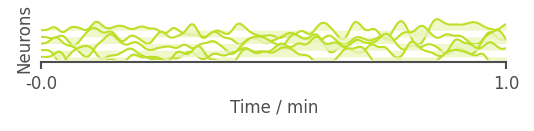

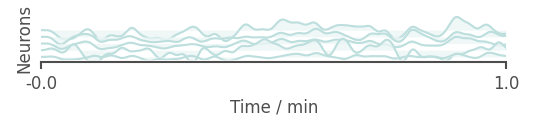

In [5]:
fig, ax = run_simulation(time_min=1,
                         Agent=Ag,
                         layers=layers,
                         train=False,               # No learning 
                         no_plot=True,
                         force_theta='constant_0',  # Fix network into inference (aka. bottom-up) mode
                         )


# See entorhinal cortex (apical, soma and basal)
EC.apical_compartment.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60,norm_by=2.5)
EC.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60,norm_by=2.5)
EC.basal_compartment.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60,norm_by=2.5)

# See hippocampus
HPC.apical_compartment.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60, norm_by=2.5)
HPC.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60, norm_by=2.5)
HPC.basal_compartment.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60,norm_by=2.5)

#See latents and features 
Latents.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60)
Features.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60)

### 2.2 Generative mode 

* Next we will run the network for 1 minute with the model in **generative mode (top-down drive)**. You should observe that somatic activity equals apical dendritic activity since the network is in generitve mode, but does not necessarily match apical dendritic activity. Also, the generative model may not be very good (all activity my just die) 

  0%|          | 0/2400 [00:00<?, ?it/s]

<Loss> = [('HPC', '7.36e-01'), ('EC', '2.09e-01')]: 100%|██████████| 2400/2400 [00:00<00:00, 3043.13it/s]


Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/EC_apical_firingrate_1444_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/EC_firingrate_1444_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/EC_basal_firingrate_1444_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/HPC_apical_firingrate_1444_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/HPC_firingrate_1444_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/HPC_basal_firingrate_1444_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/Neurons_firingrate_1444_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/Features_firingrate_1444_1.png  & .svg


(<Figure size 600x60 with 1 Axes>,
 <Axes: xlabel='Time / min', ylabel='Neurons'>)

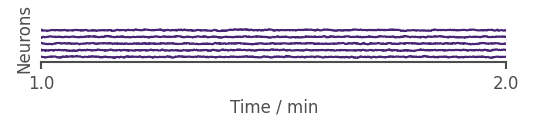

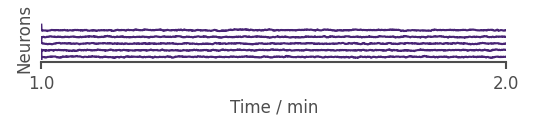

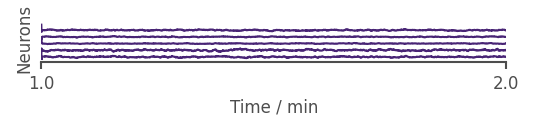

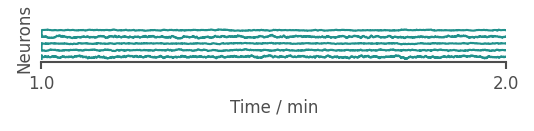

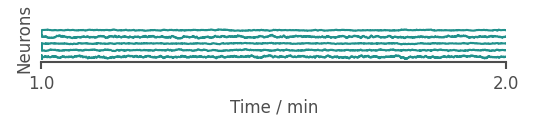

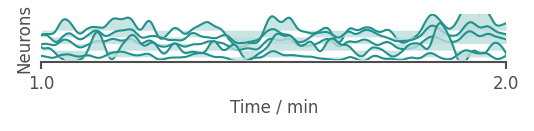

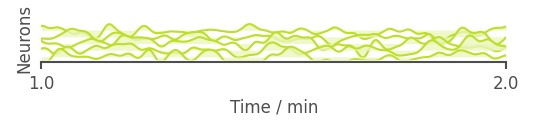

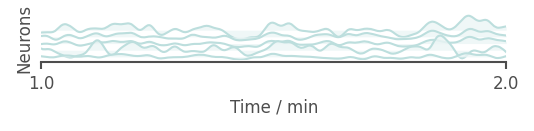

In [6]:
fig, ax = run_simulation(time_min=1,
                         Agent=Ag,
                         layers=layers,
                         train=False,                # No learning
                         no_plot=True,
                         force_theta='constant_1',   # Fix network into generative (aka. top-down) mode
)

#Entorhinal cortex
EC.apical_compartment.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60,norm_by=2.5)
EC.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60,norm_by=2.5)
EC.basal_compartment.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60,norm_by=2.5)

#Hippocampus
HPC.apical_compartment.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60, norm_by=2.5)
HPC.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60, norm_by=2.5)
HPC.basal_compartment.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60,norm_by=2.5)

#Latents and features
Latents.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60)
Features.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60)

### 2.3 Decorrelations 
* Finally, plot the self-decorrelation curves of the latents and the MEC neurons. You should observe that the latents have smooth decorrelations of ~TAU but the MEC neurons don't since the generative model is not trained to match the latents yet. 

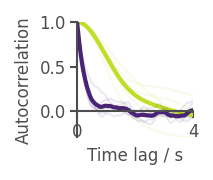

In [7]:
fig, ax = autocorrelations(Latents,EC,max_lag=4)

## 3 Train the model 

Now we train the model. All the learning rules etc. is stored inside the pyrmaidal neurons class and described in the paper. 

<Loss> = [('HPC', '5.41e-01'), ('EC', '5.02e-02')]: 100%|██████████| 72000/72000 [00:31<00:00, 2304.84it/s]


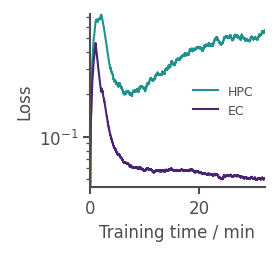

In [8]:
fig, ax = run_simulation(
                    time_min=30,
                    Agent=Ag,
                    layers=layers,
                    train=True
)

In [9]:
#briefly reset the layers with a short burst where there is no learning 
fig, ax = run_simulation(time_min=0.1,Agent=Ag,layers=layers,train=False,no_plot=True)

100%|██████████| 240/240 [00:00<00:00, 2298.34it/s]


## 4 Visualise network activity _after_ learning 

Now repeat the same steps as above and observe the difference.

### 4.1 Inference mode 

* First we will run the network for 1 minute with the model in **inference mode (bottom-up drive)**. You should observe that somatic activity equals basal dendritic activity (by definition) and, hopefully, apical dendritic activity indicating good autoencoding.

In [10]:
fig, ax = run_simulation(time_min=1,Agent=Ag,layers=layers,train=False,no_plot=True,force_theta='constant_0')

<Loss> = [('HPC', '3.84e-01'), ('EC', '6.01e-02')]: 100%|██████████| 2400/2400 [00:01<00:00, 2345.36it/s]


Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/EC_apical_firingrate_1445.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/EC_firingrate_1445.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/EC_basal_firingrate_1445.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/HPC_apical_firingrate_1445.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/HPC_firingrate_1445.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/HPC_basal_firingrate_1445.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/Neurons_firingrate_1445.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/Features_firingrate_1445.png  & .svg


(<Figure size 600x60 with 1 Axes>,
 <Axes: xlabel='Time / min', ylabel='Neurons'>)

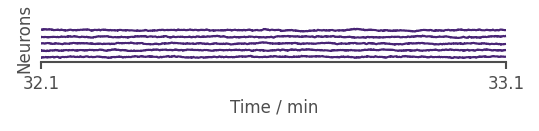

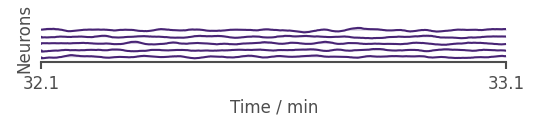

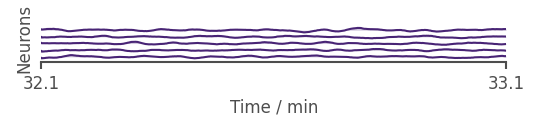

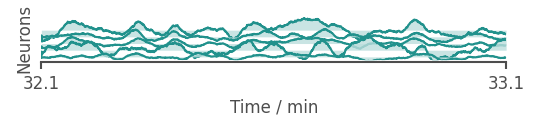

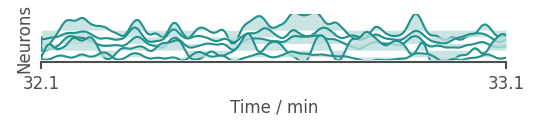

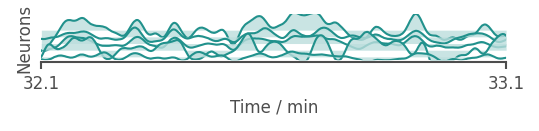

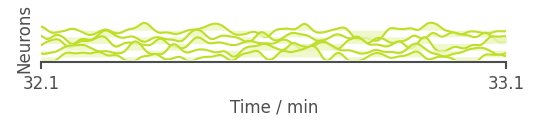

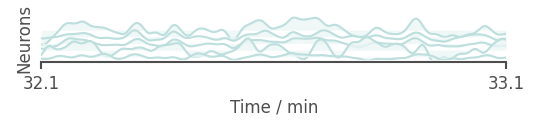

In [11]:
# Entorhinal cortex 
EC.apical_compartment.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60,norm_by=2.5)
EC.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60,norm_by=2.5)
EC.basal_compartment.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60,norm_by=2.5)

# Hippocampus
HPC.apical_compartment.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60, norm_by=2.5)
HPC.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60, norm_by=2.5)
HPC.basal_compartment.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60,norm_by=2.5)

# Latents and features
Latents.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60)
Features.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60)


### 4.2 Generative mode 

* Next we will run the network for 1 minute with the model in **generative mode (top-down drive)**. You should observe that somatic activity equals apical dendritic activity (by definition) and, hopefully, basal dendritic activity too (except in HPC where basal inputs are still driven by ground truth features, here it should be "statistically matched" but not exactly matched)

100%|██████████| 240/240 [00:00<00:00, 2165.15it/s]
<Loss> = [('HPC', '6.71e-01'), ('EC', '4.08e-02')]: 100%|██████████| 2400/2400 [00:01<00:00, 2303.54it/s]


Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/EC_apical_firingrate_1445_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/EC_firingrate_1445_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/EC_basal_firingrate_1445_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/HPC_apical_firingrate_1445_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/HPC_firingrate_1445_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/HPC_basal_firingrate_1445_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/Neurons_firingrate_1445_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/Features_firingrate_1445_1.png  & .svg


(<Figure size 600x60 with 1 Axes>,
 <Axes: xlabel='Time / min', ylabel='Neurons'>)

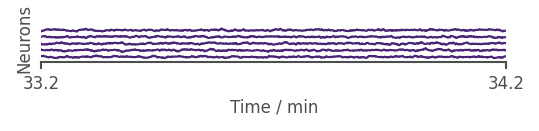

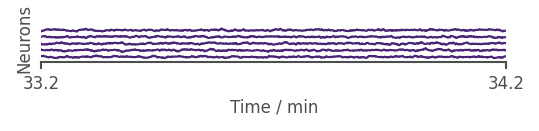

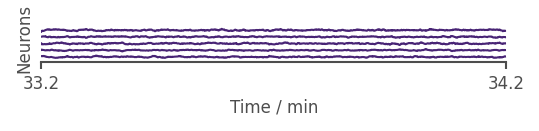

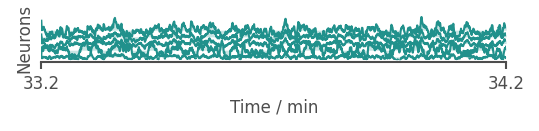

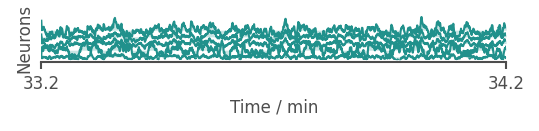

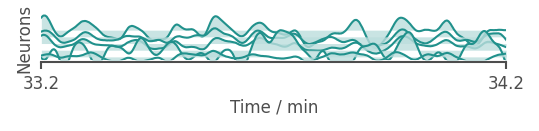

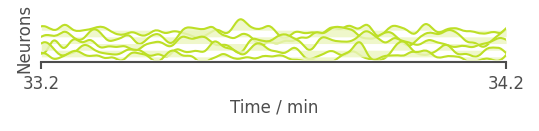

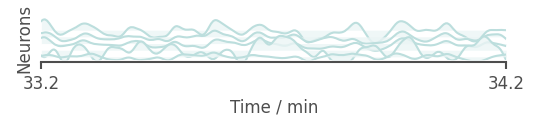

In [12]:
fig, ax = run_simulation(time_min=0.1,Agent=Ag,layers=layers,train=False,no_plot=True) #little reset
fig, ax = run_simulation(time_min=1,Agent=Ag,layers=layers,train=False,no_plot=True,force_theta='constant_1')

# Entorhinal cortex
EC.apical_compartment.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60,norm_by=2.5)
EC.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60,norm_by=2.5)
EC.basal_compartment.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60,norm_by=2.5)

# Hippocampus
HPC.apical_compartment.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60, norm_by=2.5)
HPC.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60, norm_by=2.5)
HPC.basal_compartment.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60,norm_by=2.5)

# Latents and features
Latents.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60)
Features.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60)

### 4.3 Decorrelations

Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/Neurons_firingrate_1445_2.png  & .svg
Figure saved to /Users/tomgeorge/Documents/UCL/HelmholtzHippocampus/figures/13_12_23/EC_firingrate_1445_2.png  & .svg


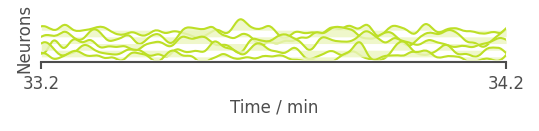

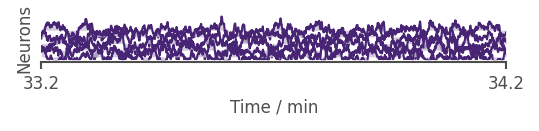

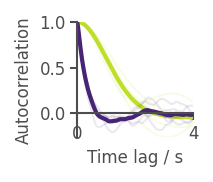

In [13]:
fig, ax = Latents.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60)
fig, ax = EC.plot_rate_timeseries(chosen_neurons='5',t_start=Ag.t-60)
fig, ax = autocorrelations(Latents,EC,max_lag=4)